In [1]:
import nest_asyncio
nest_asyncio.apply()

In [2]:
import deephyper
deephyper.__version__

'0.3.3'

In [3]:
import numpy as np
import matplotlib.pylab as plt

def load_data(nSamples=100, nGrid=128, train_test_split= 0.90):
    
    dirIn = '/lcrc/project/cosmo_ai/nramachandra/Projects/PRISM/ellipsoidal_void/data/'

    temp_data = np.load(dirIn + 'random_ellipsoids_3d.npy')[:nSamples]
    radii_data = np.load(dirIn + 'random_ellipsoids_3d_radii.npy')[:nSamples]


    split = np.int(train_test_split*temp_data.shape[0])

    train_data = temp_data[0:split, :, :, :].astype('float32')
    train_target = radii_data[0:split, :].astype('float32')
    test_data = temp_data[split:, :, :, :].astype('float32')
    test_target = radii_data[split:, :].astype('float32')

    # return (train_data[:, :nGrid, :nGrid, :nGrid], train_target), (test_data[:, :nGrid, :nGrid, :nGrid], test_target)
    # return (train_data[:, :10, 0, 0], train_data[:, :10, 0, 0]), (test_data[:, :10, 0, 0], test_data[:, :10, 0, 0])
    # return (train_data[:, :nGrid, :nGrid, :nGrid], train_data[:, :nGrid, :nGrid, :nGrid]), (test_data[:, :nGrid, :nGrid, :nGrid], test_data[:, :nGrid, :nGrid, :nGrid])

    train_images = train_data[:, :nGrid, :nGrid, :nGrid]
    test_images = test_data[:, :nGrid, :nGrid, :nGrid]
    
    loaddata = 'average' ## 'average' or 'log' for different normalization


    if loaddata == 'average':
    # RESCALING IMAGES
    #print(train_images[0,:,:,:,0])
        tmin = train_images.min()
        tmax = train_images.max()
        print('old min-max:', tmin, tmax)
        train_images = (train_images - tmin) / (tmax - tmin) # Normalize the images to [-1, 1]
        test_images = (test_images - tmin) / (tmax - tmin)
        print('new min-max:', train_images.min(), train_images.max())

        shape0 = train_images.shape[0]
        swe_train_data = train_images.reshape(shape0, nGrid, nGrid, nGrid, 1)
        # swe_train_data = train_images.reshape(shape0, nGrid, nGrid, nGrid)

        shape1 = test_images.shape[0]
        swe_test_data = test_images.reshape(shape1, nGrid, nGrid, nGrid, 1)
        # swe_test_data = test_images.reshape(shape1, nGrid, nGrid, nGrid)

        
    print(swe_train_data.shape, swe_test_data.shape)
    return (swe_train_data, swe_train_data), (swe_test_data, swe_test_data)
    
    #! to debug
    # x = np.zeros((90, 128, 128, 128, 1))
    
    # return (x, x), (x, x)
    
            


In [4]:
(train_data, _), (test_data, _) = load_data(nSamples=100, nGrid=128, train_test_split= 0.90)
print(train_data.shape, test_data.shape)

/tmp/ipykernel_2244620/4204352493.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  split = np.int(train_test_split*temp_data.shape[0])


old min-max: 0.0 1.0
new min-max: 0.0 1.0
(90, 128, 128, 128, 1) (10, 128, 128, 128, 1)
(90, 128, 128, 128, 1) (10, 128, 128, 128, 1)


In [5]:
num_epochs = 4
batch_size = 4 #4 #256
learning_rate = 1e-4 #1e-4
decay_rate = 0.1

# latent_dim = 8 #16 ###
# epsilon_mean = 0.1
# epsilon_std = 1e-4 #1e-4
nGrid= 128

In [6]:
import tensorflow as tf

from deephyper.nas import KSearchSpace
from deephyper.nas.node import ConstantNode, VariableNode
from deephyper.nas.operation import Identity, operation

Dense = operation(tf.keras.layers.Dense)
Reshape = operation(tf.keras.layers.Reshape)
Flatten = operation(tf.keras.layers.Flatten)
Conv3D = operation(tf.keras.layers.Conv3D)
Conv3DTranspose = operation(tf.keras.layers.Conv3DTranspose)


In [7]:
available_gpus = tf.config.list_physical_devices("GPU")
n_gpus = len(available_gpus)
if n_gpus > 1:
    n_gpus -= 1
is_gpu_available = n_gpus > 0

if is_gpu_available:
    print(f"{n_gpus} GPU{'s are' if n_gpus > 1 else ' is'} available.")
else:
    print("No GPU available")

7 GPUs are available.


In [8]:
import ray

if not(ray.is_initialized()):
    if is_gpu_available:
        ray.init(num_cpus=n_gpus, num_gpus=n_gpus, log_to_driver=False)            
    else:
        ray.init(num_cpus=2, log_to_driver=False)

2022-06-21 10:40:32,058	INFO services.py:1412 -- View the Ray dashboard at http://127.0.0.1:8265


In [9]:


# class SupervisedRegAutoEncoderSpace(KSearchSpace):
#     def __init__(
#         self,
#         input_shape,
#         output_shape,
#         batch_size=None,
#         seed=None,
#         units=[128, 64, 32, 16, 8, 16, 32, 64, 128],
#         num_layers=5,
#     ):
#         super().__init__(input_shape, output_shape, batch_size=batch_size, seed=seed)

#         self.units = units
#         self.num_layers = num_layers

#     def build(self):

#         inp = self.input_nodes[0]

#         # auto-encoder
#         units = [128, 64, 32, 16, 8, 16, 32, 64, 128]
#         prev_node = inp
#         d = 1
#         for i in range(len(units)):
#             vnode = VariableNode()
#             vnode.add_op(Identity())
#             if d == 1 and units[i] < units[i + 1]:
#                 d = -1
#                 for u in range(min(2, units[i]), max(2, units[i]) + 1, 2):
#                     vnode.add_op(Dense(u, tf.nn.relu))
#                 latente_space = vnode
#             else:
#                 for u in range(
#                     min(units[i], units[i + d]), max(units[i], units[i + d]) + 1, 2
#                 ):
#                     vnode.add_op(Dense(u, tf.nn.relu))
#             self.connect(prev_node, vnode)
#             prev_node = vnode

#         # out2 = ConstantNode(op=Dense(self.output_shape[0][0], name="output_0"))
#         out2 = ConstantNode(op=Dense(self.output_shape[0], name="output_0"))

#         self.connect(prev_node, out2)

# #         # regressor
# #         prev_node = latente_space
# #         # prev_node = inp
# #         for _ in range(self.num_layers):
# #             vnode = VariableNode()
# #             for i in range(16, 129, 16):
# #                 vnode.add_op(Dense(i, tf.nn.relu))

# #             self.connect(prev_node, vnode)
# #             prev_node = vnode

# #         out1 = ConstantNode(op=Dense(self.output_shape[1][0], name="output_1"))
# #         self.connect(prev_node, out1)

#         return self



In [10]:


class AutoEncoderSpace(KSearchSpace):
    def __init__(
        self,
        input_shape,
        output_shape,
        batch_size=None,
        seed=None,
        # units=[128, 64, 32, 16, 8, 16, 32, 64, 128],
        units = [128, 64, 32, 64, 128],
        num_layers=5,
    ):
        super().__init__(input_shape, output_shape, batch_size=batch_size, seed=seed)

        self.units = units
        self.num_layers = num_layers

    def build(self):

        inp = self.input_nodes[0]
          
        conv1 = ConstantNode(Conv3D(filters=128, kernel_size=3, padding='same', activation='relu'))
        self.connect(inp, conv1)
        
        conv2 = ConstantNode(Conv3D(filters=64, kernel_size=3, strides=4, padding='same', activation='relu'))
        self.connect(conv1, conv2)
        
        conv3 = ConstantNode(Conv3D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'))
        self.connect(conv2, conv3)
        
        conv4 = ConstantNode(Conv3D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'))
        self.connect(conv3, conv4)
        
        flat1 = ConstantNode(Flatten())
        self.connect(conv4, flat1)
        
        
        

        # auto-encoder
        # units = [128, 64, 32, 16, 8, 16, 32, 64, 128]
        # units = [64, 32, 16, 8, 16, 32, 64]
        units = [128, 64, 32, 64, 128]

        # prev_node = inp
        prev_node = flat1

        d = 1
        for i in range(len(units)):
            vnode = VariableNode()
            vnode.add_op(Identity())
            if d == 1 and units[i] < units[i + 1]:
                d = -1
                for u in range(min(2, units[i]), max(2, units[i]) + 1, 2):
                    vnode.add_op(Dense(u, tf.nn.relu))
                latente_space = vnode
            else:
                for u in range(min(units[i], units[i + d]), max(units[i], units[i + d]) + 1, 2):
                    vnode.add_op(Dense(u, tf.nn.relu))
            self.connect(prev_node, vnode)
            prev_node = vnode
            
        #####################
        # regressor
        # prev_node = latente_space
        # prev_node = inp
        
        for _ in range(self.num_layers):
            vnode = VariableNode()
            for i in range(16, 129, 16):
                vnode.add_op(Dense(i, tf.nn.relu))

            self.connect(prev_node, vnode)
            prev_node = vnode

        # out1 = ConstantNode(op=Dense(self.output_shape[1][0], name="output_1"))
        # self.connect(prev_node, out1)
        
        #####################
        

        out2 = ConstantNode(op=Dense(64, name="output_0"))
        self.connect(prev_node, out2)
        
        reshape1 = ConstantNode(Reshape(target_shape = (4,4,4,1)) )
        self.connect(out2, reshape1)
          
        convT1 = ConstantNode(Conv3DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'))
        self.connect(reshape1, convT1)
        
        convT2 = ConstantNode(Conv3DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'))
        self.connect(convT1, convT2)
        
        convT3 = ConstantNode(Conv3DTranspose(filters=64, kernel_size=3, strides=4, padding='same', activation='relu'))
        self.connect(convT2, convT3)
        
        convT4 = ConstantNode(Conv3DTranspose(filters=128, kernel_size=3, strides=2, padding='same', activation='relu'))
        self.connect(convT3, convT4)

        return self



/lcrc/project/cosmo_ai/nramachandra/Projects/PRISM/saul_tests/deephyper/deephyper/nas/_keras_search_space.py:182: RuntimeWarning: The output tensor of shape (None, 128, 128, 128, 128) doesn't match the expected shape (128, 128, 128, 1)!
  warnings.warn(
E0621 10:40:40.780892376 2244620 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0621 10:40:41.385385239 2244620 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


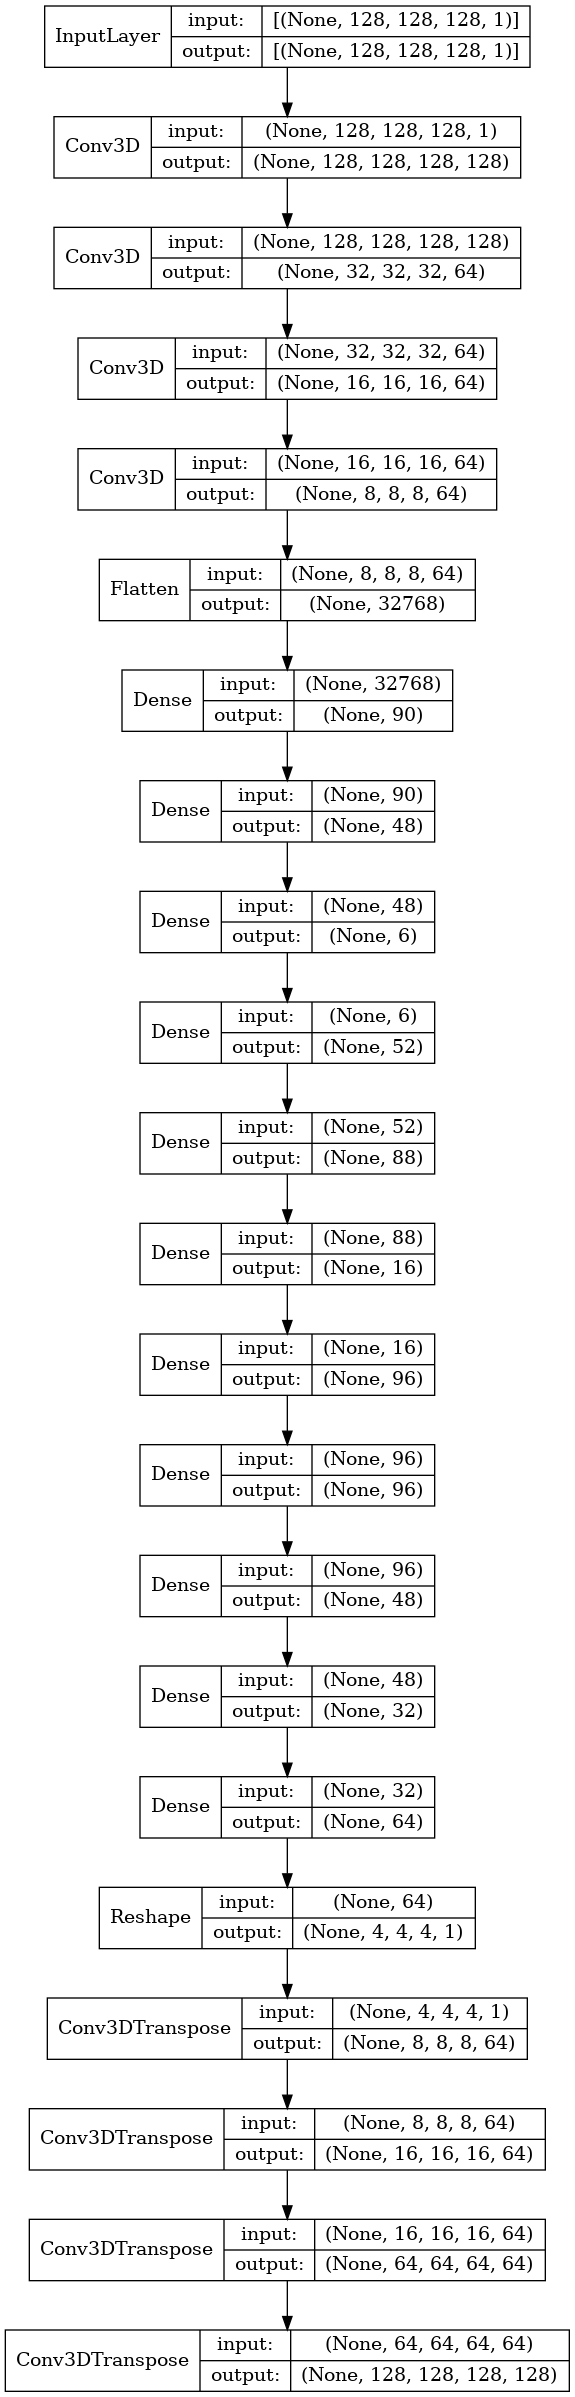

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.utils import plot_model

# shapes = dict(input_shape=..., output_shape=...)
#! shape does not include batch size
shapes = dict(input_shape=(nGrid, nGrid, nGrid, 1), output_shape=(nGrid, nGrid, nGrid, 1))
# shapes = dict(input_shape=(100, nGrid, nGrid, nGrid, 1), output_shape=(100, nGrid, nGrid, nGrid, 1))

space = AutoEncoderSpace(**shapes).build()
model = space.sample()
plot_model(model, show_shapes=True, show_layer_names=False)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_0 (InputLayer)        [(None, 128, 128, 128, 1  0         
                             )]                                  
                                                                 
 conv3d (Conv3D)             (None, 128, 128, 128, 12  3584      
                             8)                                  
                                                                 
 conv3d_1 (Conv3D)           (None, 32, 32, 32, 64)    221248    
                                                                 
 conv3d_2 (Conv3D)           (None, 16, 16, 16, 64)    110656    
                                                                 
 conv3d_3 (Conv3D)           (None, 8, 8, 8, 64)       110656    
                                                                 
 flatten (Flatten)           (None, 32768)             0     

/lcrc/project/cosmo_ai/nramachandra/Projects/PRISM/saul_tests/deephyper/deephyper/nas/_keras_search_space.py:182: RuntimeWarning: The output tensor of shape (None, 128, 128, 128, 128) doesn't match the expected shape (128, 128, 128, 1)!
  warnings.warn(
E0621 10:40:41.832867617 2244620 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0621 10:40:41.922431969 2244620 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


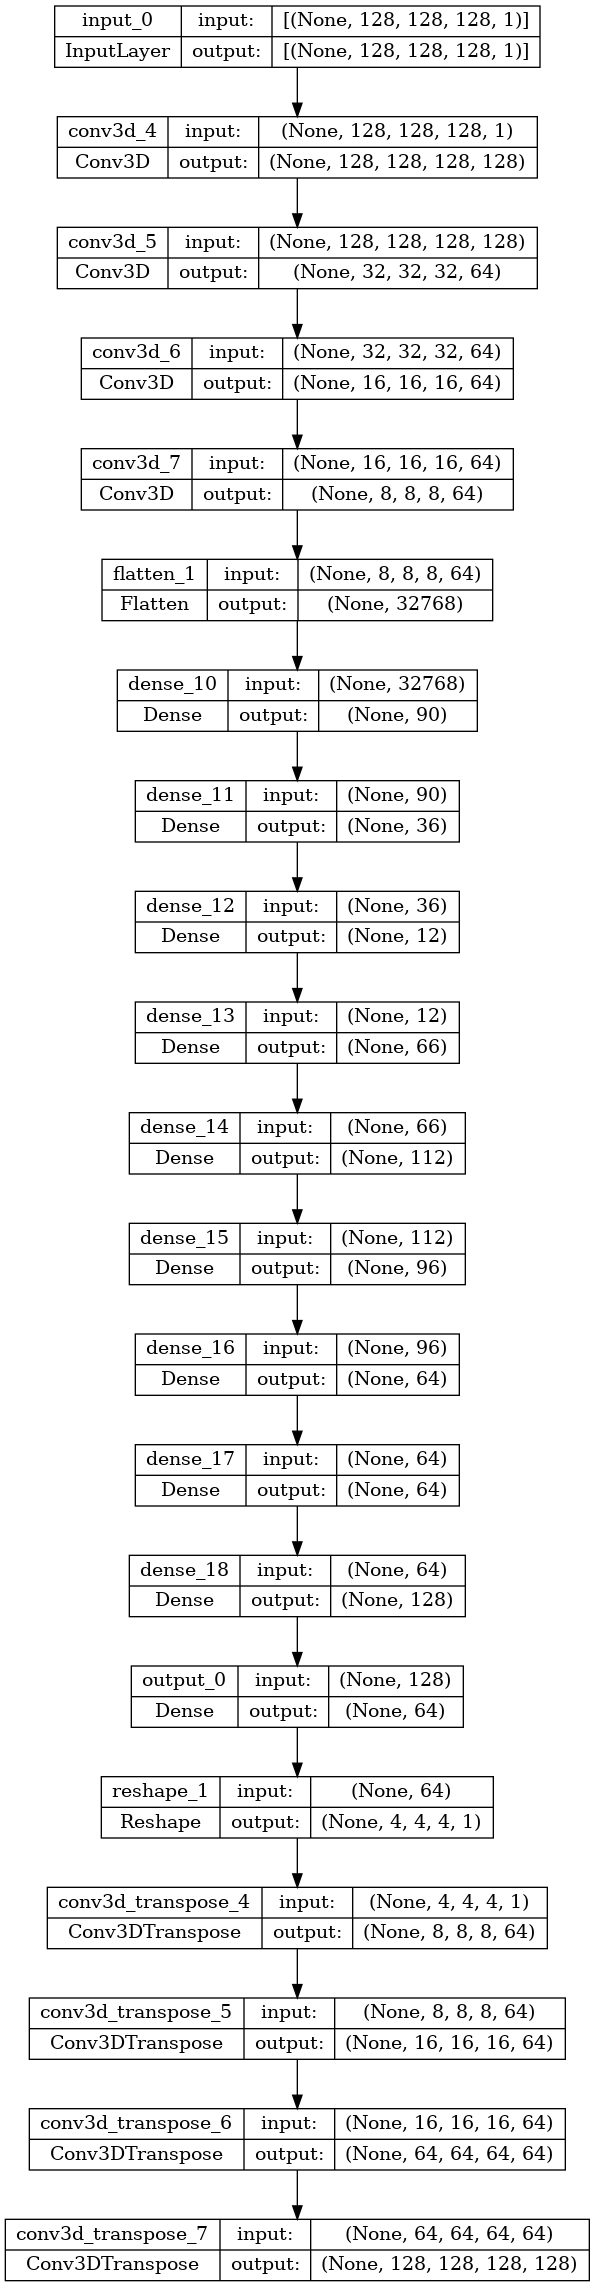

In [13]:
from tensorflow.keras.utils import plot_model

# shapes = dict(input_shape=(10,), output_shape=(10,))
#! shape does not include batch_size
shapes = dict(input_shape=(nGrid, nGrid, nGrid, 1), output_shape=(nGrid, nGrid, nGrid, 1))
space = AutoEncoderSpace(**shapes).build()
model = space.sample()
plot_model(model, show_shapes=True)

/lcrc/project/cosmo_ai/nramachandra/Projects/PRISM/saul_tests/deephyper/deephyper/nas/_keras_search_space.py:182: RuntimeWarning: The output tensor of shape (None, 128, 128, 128, 128) doesn't match the expected shape (128, 128, 128, 1)!
  warnings.warn(
E0621 10:40:42.337843890 2244620 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0621 10:40:42.426021540 2244620 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
/lcrc/project/cosmo_ai/nramachandra/Projects/PRISM/saul_tests/deephyper/deephyper/nas/_keras_search_space.py:182: RuntimeWarning: The output tensor of shape (None, 128, 128, 128, 128) doesn't match the expected shape (128, 128, 128, 1)!
  warnings.warn(
E0621 10:40:42.784496462 2244620 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0621 10:40:42.873209879 2244620 fork_posix.cc:76]           Other threads are currently call

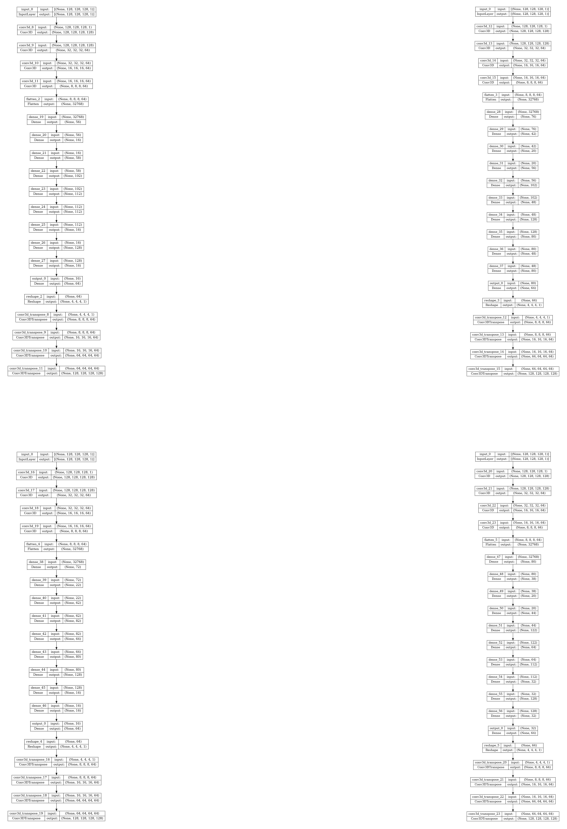

In [14]:
import matplotlib.image as mpimg
from tensorflow.keras.utils import plot_model

shapes = dict(input_shape=(nGrid, nGrid, nGrid, 1, ), output_shape=(nGrid, nGrid, nGrid, 1, ))
space = AutoEncoderSpace(**shapes).build()
    

images = []
plt.figure(figsize=(15,15))
for i in range(4):
    
    model = space.sample()
    plt.subplot(2,2,i+1)
    plot_model(model, "random_model" + str(i) +".png", show_shapes=True, show_layer_names=True)
    image = mpimg.imread("random_model" + str(i) +".png")
    plt.imshow(image)
    plt.axis('off')

plt.show()

In [15]:
from deephyper.problem import NaProblem
# from sklearn.preprocessing import StandardScaler


# def stdscaler():
#     return StandardScaler()


problem = NaProblem()

# Bind a function which returns (train_input, train_output), (valid_input, valid_output)
# problem.load_data(load_data_train_valid)
problem.load_data(load_data)


# Bind a function which return a scikit-learn preprocessor (with fit, fit_transform, inv_transform...etc)
#! no supported for array of dim > 2 
# problem.preprocessing(stdscaler)

# Bind a function which returns a search space and give some arguments for the `build` method
# problem.search_space(RegressionSpace, num_layers=3)
problem.search_space(AutoEncoderSpace)

# Define a set of fixed hyperparameters for all trained neural networks
problem.hyperparameters(
    batch_size=batch_size,
    learning_rate=learning_rate,
    optimizer="adam",
    num_epochs=num_epochs,
    callbacks=dict(
        EarlyStopping=dict(monitor="val_loss", mode="min", verbose=0, patience=30)
    ),
    verbose=1, #! useful to debug and see if training is starting the Keras progress bar should show up
)

# Define the loss to minimize
problem.loss("mse")

# Define complementary metrics
problem.metrics([])

# Define the maximized objective. Here we take the negative of the validation loss.
problem.objective("-val_loss")

problem

Problem is:
    - search space   : __main__.AutoEncoderSpace
    - data loading   : __main__.load_data
    - preprocessing  : None
    - hyperparameters: 
        * verbose: 1
        * batch_size: 4
        * learning_rate: 0.0001
        * optimizer: adam
        * num_epochs: 4
        * callbacks: {'EarlyStopping': {'monitor': 'val_loss', 'mode': 'min', 'verbose': 0, 'patience': 30}}
    - loss           : mse
    - metrics        : 
    - objective      : -val_loss

In [16]:
from deephyper.evaluator import Evaluator
from deephyper.evaluator.callback import LoggerCallback


def get_evaluator(run_function):
    
    # Default arguments for Ray: 1 worker and 1 worker per evaluation
    method_kwargs = {
        "num_cpus": 1, 
        "num_cpus_per_task": 1,
        "callbacks": [LoggerCallback()] # To interactively follow the finished evaluations,
    }

    # If GPU devices are detected then it will create 'n_gpus' workers
    # and use 1 worker for each evaluation
    if is_gpu_available:
        method_kwargs["num_cpus"] = n_gpus
        method_kwargs["num_gpus"] = n_gpus
        method_kwargs["num_cpus_per_task"] = 1
        method_kwargs["num_gpus_per_task"] = 1

    evaluator = Evaluator.create(
        run_function, 
        method="ray", 
        method_kwargs=method_kwargs
    )
    print(f"Created new evaluator with {evaluator.num_workers} worker{'s' if evaluator.num_workers > 1 else ''} and config: {method_kwargs}", )
    
    return evaluator

In [17]:
results = {} # used to store the results of different search algorithms
max_evals = 5 # maximum number of iteratins for all searches
from deephyper.nas.run import run_base_trainer

### For debugging
1. active the logging to a deephyper.log file
2. collect the space as a dict
3. fix an architecture in arch_seq key
4. execute the run_base_trainer

In [18]:
debug_mode = True

if debug_mode:
    # code to help debug what is happening inside the `run-function` (model training)
    import sys
    import logging


    logging.basicConfig(
                # stream=sys.stdout,
                filename="deephyper.log",
                level=logging.INFO,
                format="%(asctime)s - %(levelname)s - %(filename)s:%(funcName)s - %(message)s",
                force=True,
            )


    config = problem.space
    choice = [0 for _ in space.choices()]
    config["arch_seq"] = choice

    print(run_base_trainer(config))
    print('done')

E0621 10:40:47.869163319 2244620 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
/tmp/ipykernel_2244620/4204352493.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  split = np.int(train_test_split*temp_data.shape[0])


old min-max: 0.0 1.0
new min-max: 0.0 1.0
(90, 128, 128, 128, 1) (10, 128, 128, 128, 1)


/lcrc/project/cosmo_ai/nramachandra/Projects/PRISM/saul_tests/deephyper/deephyper/nas/_keras_search_space.py:182: RuntimeWarning: The output tensor of shape (None, 128, 128, 128, 128) doesn't match the expected shape (128, 128, 128, 1)!
  warnings.warn(


Epoch 1/4


2022-06-21 10:41:05.496607: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


23/23 [==============================] - 27s 553ms/step - loss: 0.3089 - val_loss: 0.3255
Epoch 2/4
23/23 [==============================] - 10s 449ms/step - loss: 0.3071 - val_loss: 0.3231
Epoch 3/4
23/23 [==============================] - 10s 449ms/step - loss: 0.3042 - val_loss: 0.3189
Epoch 4/4
23/23 [==============================] - 10s 448ms/step - loss: 0.2996 - val_loss: 0.3128
-0.31281355023384094
done


In [19]:
get_evaluator(run_base_trainer)

Created new evaluator with 7 workers and config: {'num_cpus': 7, 'num_cpus_per_task': 1, 'callbacks': [<deephyper.evaluator.callback.LoggerCallback object at 0x147f2d16b340>], 'num_gpus': 7, 'num_gpus_per_task': 1}


In [20]:
random_search = False

if random_search:
    from deephyper.search.nas import Random

    random_search = Random(problem, get_evaluator(run_base_trainer), log_dir="random_search")
    results["random"] = random_search.search(max_evals=max_evals)

In [21]:
from deephyper.search.nas import RegularizedEvolution

regevo_search = RegularizedEvolution(problem, get_evaluator(run_base_trainer), log_dir="regevo_search")
results["regevo"] = regevo_search.search(max_evals=max_evals)

Created new evaluator with 7 workers and config: {'num_cpus': 7, 'num_cpus_per_task': 1, 'callbacks': [<deephyper.evaluator.callback.LoggerCallback object at 0x1480b0091e80>], 'num_gpus': 7, 'num_gpus_per_task': 1}


/tmp/ipykernel_2244620/4204352493.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  split = np.int(train_test_split*temp_data.shape[0])


old min-max: 0.0 1.0
new min-max: 0.0 1.0
(90, 128, 128, 128, 1) (10, 128, 128, 128, 1)


RayTaskError(InternalError): [36mray::run_base_trainer()[39m (pid=2245472, ip=10.70.150.15)
  File "/lcrc/project/cosmo_ai/nramachandra/Projects/PRISM/saul_tests/deephyper/deephyper/nas/run/_run_base_trainer.py", line 110, in run_base_trainer
    trainer = BaseTrainer(config=config, model=model)
  File "/lcrc/project/cosmo_ai/nramachandra/Projects/PRISM/saul_tests/deephyper/deephyper/nas/trainer/_base.py", line 62, in __init__
    self.set_dataset_train()
  File "/lcrc/project/cosmo_ai/nramachandra/Projects/PRISM/saul_tests/deephyper/deephyper/nas/trainer/_base.py", line 281, in set_dataset_train
    self.dataset_train = tf.data.Dataset.from_tensor_slices(
  File "/home/nramachandra/.local/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 809, in from_tensor_slices
    return TensorSliceDataset(tensors, name=name)
  File "/home/nramachandra/.local/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 4551, in __init__
    element = structure.normalize_element(element)
  File "/home/nramachandra/.local/lib/python3.9/site-packages/tensorflow/python/data/util/structure.py", line 125, in normalize_element
    ops.convert_to_tensor(t, name="component_%d" % i, dtype=dtype))
  File "/home/nramachandra/.local/lib/python3.9/site-packages/tensorflow/python/profiler/trace.py", line 183, in wrapped
    return func(*args, **kwargs)
  File "/home/nramachandra/.local/lib/python3.9/site-packages/tensorflow/python/framework/ops.py", line 1640, in convert_to_tensor
    ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
  File "/home/nramachandra/.local/lib/python3.9/site-packages/tensorflow/python/framework/tensor_conversion_registry.py", line 48, in _default_conversion_function
    return constant_op.constant(value, dtype, name=name)
  File "/home/nramachandra/.local/lib/python3.9/site-packages/tensorflow/python/framework/constant_op.py", line 267, in constant
    return _constant_impl(value, dtype, shape, name, verify_shape=False,
  File "/home/nramachandra/.local/lib/python3.9/site-packages/tensorflow/python/framework/constant_op.py", line 279, in _constant_impl
    return _constant_eager_impl(ctx, value, dtype, shape, verify_shape)
  File "/home/nramachandra/.local/lib/python3.9/site-packages/tensorflow/python/framework/constant_op.py", line 304, in _constant_eager_impl
    t = convert_to_eager_tensor(value, ctx, dtype)
  File "/home/nramachandra/.local/lib/python3.9/site-packages/tensorflow/python/framework/constant_op.py", line 102, in convert_to_eager_tensor
    return ops.EagerTensor(value, ctx.device_name, dtype)
tensorflow.python.framework.errors_impl.InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
# We can now compare the search trajectories for different algorithms.

def max_score(l):
    r = [l[0]]
    for el in l[1:]:
        r.append(max(r[-1], el))
    return r

width = 8
height = width/1.618
plt.figure(figsize=(width, height))

for k, result in results.items():
    plt.plot(max_score(results[k].objective), label=k)

plt.legend()

plt.show()

## AutoDEUQ: Automated Deep Ensemble with Uncertainty Quantification

AutoDEUQ is an algorithm in 2 steps:
1. joint hyperparameter and neural architecture search to generate a catalog of models.
2. build an ensemble from the catalog

To this end we start by editing slightly the previous `RegressionFactory` by adding the `DistributionLambda` layer as output.

In [ ]:
import tensorflow_probability as tfp
tfd = tfp.distributions

In [ ]:
def nll(y, rv_y):
    """Negative log likelihood for Tensorflow probability.
    
    Args:
        y: true data.
        rv_y: learned (predicted) probability distribution.
    """
    return -rv_y.log_prob(y)

In [ ]:
DistributionLambda = operation(tfp.layers.DistributionLambda)

In [ ]:
problem_uq = NaProblem()

problem_uq.load_data(load_data)

#problem_uq.preprocessing(stdscaler)

problem_uq.search_space(AutoEncoderSpace, num_layers=3)

problem_uq.hyperparameters(
    batch_size=problem_uq.add_hyperparameter((10,100), "batch_size"),
    learning_rate=problem_uq.add_hyperparameter(
        (1e-4, 0.1, "log-uniform"),
        "learning_rate",
    ),
    optimizer=problem_uq.add_hyperparameter(
        ["sgd", "rmsprop", "adagrad", "adam", "adadelta", "adamax", "nadam"],
        "optimizer",
    ),
    patience_ReduceLROnPlateau=problem_uq.add_hyperparameter(
        (10, 20), "patience_ReduceLROnPlateau"
    ),
    patience_EarlyStopping=problem_uq.add_hyperparameter(
        (20, 30), "patience_EarlyStopping"
    ),
    num_epochs=num_epochs,
    callbacks=dict(
        ReduceLROnPlateau=dict(monitor="val_loss", mode="min", verbose=0, patience=5),
        EarlyStopping=dict(monitor="val_loss", mode="min", verbose=0, patience=10),
        # We save trained models in neural architecture search
        ModelCheckpoint=dict(
            monitor="val_loss",
            mode="min",
            save_best_only=True,
            verbose=0,
            filepath="model.h5",
            save_weights_only=False,
        ),
    ),
)

problem_uq.loss(nll)

problem_uq.metrics([])

# The objective is maximized so we take the negative of the validation loss
# where the loss is minimized
problem_uq.objective("-val_loss")

problem_uq

In [ ]:
results_uq = {}

In [ ]:
from deephyper.search.nas import AgEBO
import os
import shutil

if os.path.exists("agebo_search"):
    shutil.rmtree("agebo_search")

# "n_jobs" is the number of processes used to refresh the state of the surrogate model used in AgEBO 
agebo_search = AgEBO(problem_uq, get_evaluator(run_base_trainer), log_dir="agebo_search", n_jobs=7)

results_uq["agebo"] = agebo_search.search(max_evals=10)

In [ ]:
results_uq["agebo"]

In [ ]:
(x, y), (vx, vy) = load_data()
# (tx , ty) = load_data_test()
s_x = x
s_y = y
s_vx = vx
s_vy = vy

In [ ]:
x.flatten().shape

In [ ]:
from deephyper.ensemble import UQBaggingEnsembleRegressor

In [ ]:
# ensemble = UQBaggingEnsembleRegressor(
#     model_dir="agebo_search/save/model",
#     loss=nll,  # default is nll
#     size=10,
#     verbose=True,
#     ray_address="auto",
#     num_cpus=1,
#     num_gpus=1 if is_gpu_available else None,
#     selection="topk",
# )


ensemble = UQBaggingEnsembleRegressor(
    model_dir="agebo_search/save/model",
    loss=nll,
    size=10,
    verbose=True,
    ray_address="auto",
    num_cpus=1,
    num_gpus=1 if is_gpu_available else None,
    selection="topk",
)

ensemble.fit(s_vx, s_vy)

print(f"Selected {len(ensemble.members_files)} members are: ", ensemble.members_files)